This noteboook contains python and R code to produce Figure 3 - model monitoring in production

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import max as max_

prod_df = spark.read.load("/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/monitoring_eri_n3_prediction_labels")
max_date = prod_df.select(max_("process_date")).collect()[0][0]

filter_prod_df = prod_df.filter(F.col("process_date")==max_date).\
  filter(F.col("model_version")==35).\
  filter(F.col("updated_at_day") > "2022-04-11").\
  withColumnRenamed("date", "prod_date").\
  withColumnRenamed("mrn", "prod_mrn")

model_42_df = spark.read.load("/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/bhe_vae_knn_v42_prod")
model_42_df = model_42_df.withColumn("aggregation_date", F.trunc("updated_at", "week")).\
  select("mrn", "date", "candidate_predicted_risk", "updated_at", "aggregation_date")

prod_42_df = filter_prod_df.join(model_42_df, (filter_prod_df.prod_mrn==model_42_df.mrn) & (filter_prod_df.prod_date==model_42_df.date), "inner"). \
  select(
    "date",
    "mrn",
    "label",
    "30_days_label",
    "updated_at_day",
    "updated_at_week",
    "updated_at_quarter",
    "candidate_predicted_risk")

filter_prod_df.createOrReplaceTempView("prod_df")
prod_42_df.createOrReplaceTempView("prod_df")
model_42_df.createOrReplaceTempView("model_42_df")

all_prod_df = prod_df.filter(F.col("process_date")==max_date)
all_prod_df.createOrReplaceTempView("all_prod_df")

quality_df = spark.read.load("/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/monitoring_quality")
psi_df = quality_df.filter(F.col("metric")=="psi").\
  filter(F.col("model_version")==35).\
  filter(F.col("process_date") > "2022-04-11")
    
psi_df.createOrReplaceTempView("psi_df")

In [0]:
%r
library(SparkR)

prod_df <- sql("SELECT * FROM prod_df")
prod_df <- as.data.frame(prod_df)
prod_df$y <- prod_df$label
prod_df$prediction <- prod_df$candidate_predicted_risk

model_42_df <- sql("SELECT * FROM model_42_df")
model_42_df <- as.data.frame(model_42_df)
model_42_df$prediction <- model_42_df$candidate_predicted_risk

all_prod_df <- sql("SELECT * FROM all_prod_df")
all_prod_df <- as.data.frame(all_prod_df)
all_prod_df$y <- all_prod_df$label
all_prod_df$prediction <- all_prod_df$predicted_risk

psi_agg_df <- sql("SELECT * FROM psi_df")
psi_agg_df <- as.data.frame(psi_agg_df)
psi_week_df <- psi_agg_df[psi_agg_df$agg_level=="week",]
psi_year_df <- psi_agg_df[psi_agg_df$agg_level=="year",]


Attaching package: ‘SparkR’

The following object is masked _by_ ‘.GlobalEnv’:

    setLocalProperty

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union


In [0]:
%r
library(ggplot2)
library(pROC)
library(gridExtra)
library(knitr)
library(plyr)
library(tidyverse)

install.packages("cowplot")
library(cowplot)

ronin_colors <- c("#315677", "#3392c0", "#b5d5e7", "#ffab40", "#637176", "#980000")

* installing *source* package ‘cowplot’ ...
** package ‘cowplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cowplot)

Attaching package: ‘ggplot2’

The following object is masked from ‘package:SparkR’:

    expr

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:SparkR’:

    cov, var

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘plyr’

The following objects are masked from ‘package:SparkR’:

    arrange, count, desc, join, mutate, rename, summarize, t

In [0]:
%r
# restrict tables to the monitoring time period, 4/11/22 - 7/4/22 (based on aggregation_date or updated_at_week)

prod_df <- prod_df %>%
  filter(updated_at_week >= "2022-04-11") %>%
  filter(updated_at_week < "2022-07-04")

model_42_df <- model_42_df %>%
  filter(aggregation_date >= "2022-04-11") %>%
  filter(aggregation_date < "2022-07-04")

psi_week_df <- psi_week_df %>%
  filter(aggregation_date >= "2022-04-11") %>%
  filter(aggregation_date < "2022-07-04")

In [0]:
%run ./calibration_utils

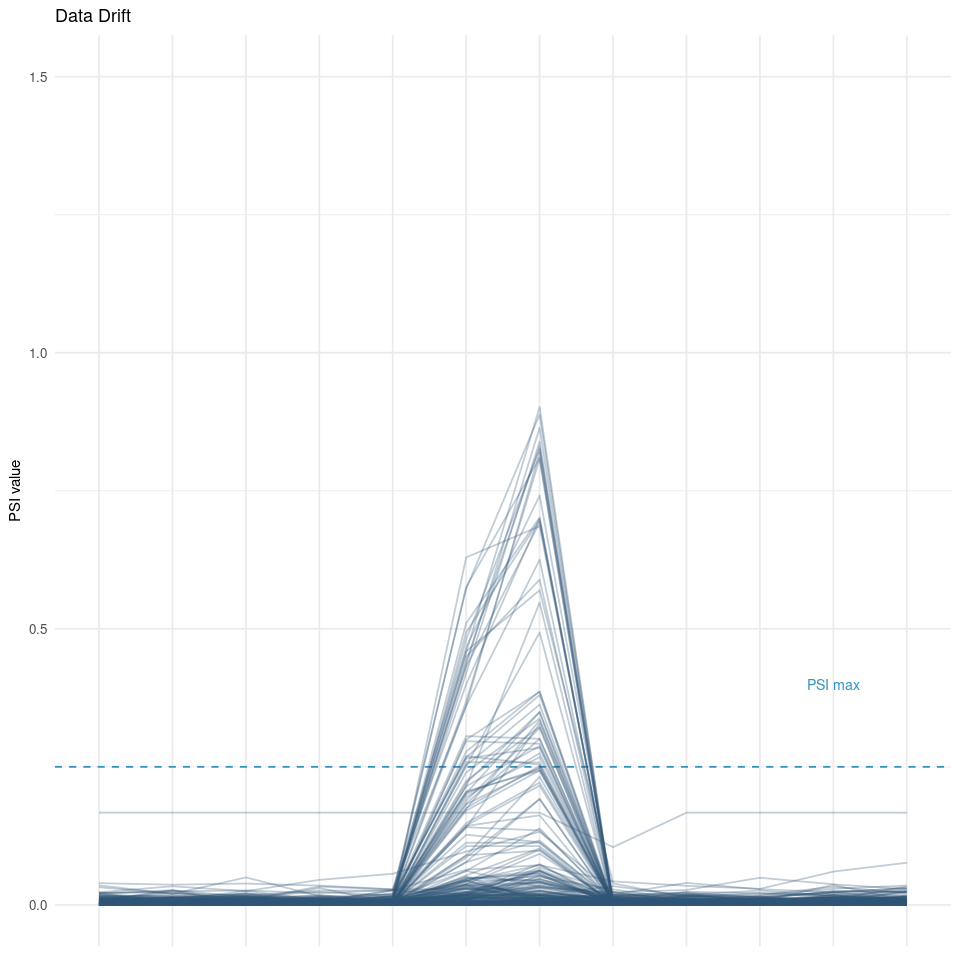

In [0]:
%r
#psi plot
options(repr.plot.width=500, repr.plot.height=300)

# turn aggregation_date into a weekly count (starting at 1)
weeks <- unique(psi_week_df$aggregation_date)
weeks[order(weeks, decreasing=F)]

week_1 <- min(weeks)
psi_week_df$week_count <- NULL
psi_week_df$week_count <- ((psi_week_df$aggregation_date - week_1) / 7) + 1

psi_week_df <- psi_week_df %>% 
  filter(aggregation_date >= "2022-04-11")

psi_p2 <- ggplot(psi_week_df, aes(x=as.factor(aggregation_date), y=value, group=feature)) + 
  geom_hline(yintercept=0.25, color=ronin_colors[2], linetype=2) +
  geom_line(color=ronin_colors[1], alpha=0.3) + 
  annotate(geom="text", label="PSI max", x=11, y=0.4, color=ronin_colors[2], size=3) +
  theme_minimal() +
  ylab("PSI value") + 
  xlab("Monitoring Week") +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  coord_cartesian(ylim=c(0, 1.5)) +
  ggtitle("Data Drift") +
  theme(
    #axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    title=element_text(size=9),
    text=element_text(size=10),
    axis.text.x=element_blank(),
    axis.title.x=element_blank())

psi_p2

In [0]:
%r
# turn updated_at_week into a weekly count (starting at 1)
weeks <- unique(prod_df$updated_at_week)
weeks[order(weeks, decreasing=F)]

week_1 <- min(weeks)
prod_df$week_count <- NULL
prod_df$week_count <- ((prod_df$updated_at_week - week_1) / 7) + 1

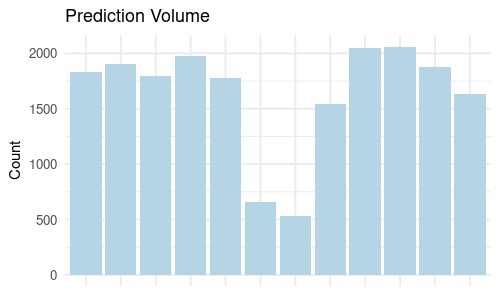

In [0]:
%r
# plot number of predictions per week
vol_p <- ggplot(model_42_df, aes(x=as.factor(aggregation_date))) + 
  geom_bar(fill=ronin_colors[3]) +
  theme_minimal() +
  ylab("Count") + 
  xlab("Monitoring Week") +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  ggtitle("Prediction Volume") +
  theme(
    #axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    axis.text.x=element_blank(),
    axis.title.x=element_blank(),
    title=element_text(size=9),
    text=element_text(size=10))

options(repr.plot.width=500, repr.plot.height=300)
vol_p

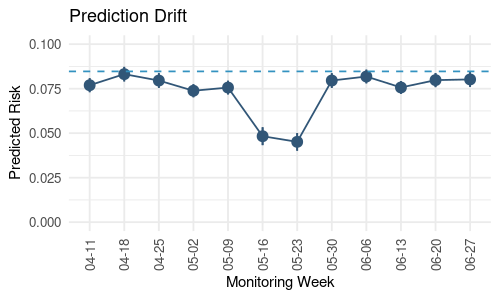

In [0]:
%r
#plot predictions per week
summary_df <- aggregate(
  model_42_df$prediction, 
  by=list(model_42_df$aggregation_date), 
  FUN=function(x) c(
    mean=mean(x), 
    sd=sd(x), 
    ci_lower=mean(x) - 1.96*sd(x)/sqrt(length(x)), 
    ci_upper=mean(x) + 1.96*sd(x)/sqrt(length(x))))

summary_df <- do.call(data.frame, summary_df)
  
pred_p <- ggplot(summary_df, aes(x=as.factor(Group.1), y=x.mean, ymin=x.ci_lower, ymax=x.ci_upper, group=1)) + 
  geom_pointrange(col=ronin_colors[1]) + 
  geom_linerange(col=ronin_colors[1]) +
  geom_line(col=ronin_colors[1]) +
  geom_hline(yintercept=0.0847, col=ronin_colors[2], linetype=2) +
  #annotate(geom="text", x=12, y=0.095, label="Training Predicted Risk", col=ronin_colors[2], size=3) +
  ylab("Predicted Risk") +
  xlab("Monitoring Week") +
  coord_cartesian(ylim=c(0, 0.1)) +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  ggtitle("Prediction Drift") +
  theme_minimal() +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
        title=element_text(size=9),
        text=element_text(size=10))

options(repr.plot.width=500, repr.plot.height=300)  
pred_p  

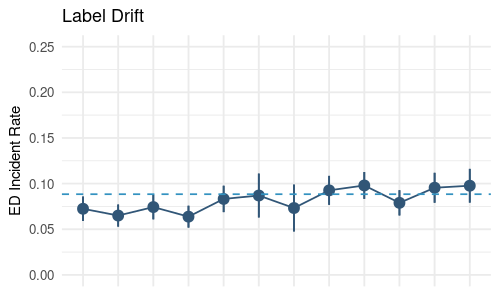

In [0]:
%r
# plot of label rate - concept drift
summary_df <- aggregate(
  prod_df$label, 
  by=list(prod_df$updated_at_week), 
  FUN=function(x) c(
    mean=mean(x), 
    sd=sd(x), 
    ci_lower=mean(x) - 1.96*sd(x)/sqrt(length(x)), 
    ci_upper=mean(x) + 1.96*sd(x)/sqrt(length(x))))

summary_df <- do.call(data.frame, summary_df)

options(repr.plot.width=500, repr.plot.height=300)
  
ed_p <- ggplot(summary_df, aes(x=as.factor(Group.1), y=x.mean, ymin=x.ci_lower, ymax=x.ci_upper, group=1)) + 
  geom_pointrange(col=ronin_colors[1]) + 
  geom_linerange(col=ronin_colors[1]) +
  geom_line(col=ronin_colors[1]) +
  geom_hline(yintercept=0.0884, col=ronin_colors[2], linetype=2) +
  #annotate(geom="text", x=3.5, y=0.095, label="Training ED Rate", col=ronin_colors[2], size=3) +
  ylab("ED Incident Rate") +
  xlab("Monitoring Week") +
  coord_cartesian(ylim=c(0, 0.25)) +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  ggtitle("Label Drift") +
  theme_minimal() +
  theme(
    #axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    title=element_text(size=9),
    axis.text.x=element_blank(),
    axis.title.x=element_blank(),
    text=element_text(size=10))

ed_p

In [0]:
%r
# Calc AUC (with CI by week)

auc_results <- data.frame(
  week_count=1:max(prod_df$week_count), 
  week_date=rep(NA, max(prod_df$week_count)),
  auc=rep(NA, max(prod_df$week_count)),
  auc_lower=rep(NA, max(prod_df$week_count)),
  auc_upper=rep(NA, max(prod_df$week_count)))

for (i in 1:max(prod_df$week_count)) {
  week_df <- prod_df[prod_df$week_count == i,]
  week_auc <- auc_results[auc_results$week_count == i,]
  
  week_date <- prod_df[prod_df$week_count == i,]$updated_at_week[1]  
  week_auc$week_date <- week_date
  
  if (length(unique(week_df$label))==1) {
    week_auc$auc <- 0
    week_auc$auc_lower <- 0
    week_auc$auc_upper <- 0
    
  } else {
    res <- roc(week_df$label, week_df$prediction, ci=TRUE, ci.method="bootstrap")
    week_auc$auc <- res$auc
    week_auc$auc_lower <- res$ci[1]
    week_auc$auc_upper <- res$ci[3]
  }
  
  auc_results[auc_results$week_count==i,] <- week_auc
}

# for some reason week_date got converted to a number
auc_results$week_date <- as.Date(auc_results$week_date, origin="1970-01-01")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases

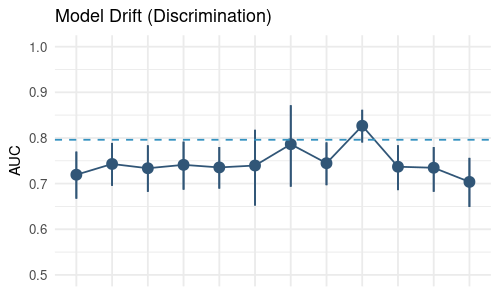

In [0]:
%r 
# plot AUC by week
options(repr.plot.width=500, repr.plot.height=300)
  
auc_p <- ggplot(auc_results, aes(x=as.factor(week_date), y=auc, ymin=auc_lower, ymax=auc_upper, group=1)) + 
  geom_pointrange(col=ronin_colors[1]) + 
  geom_linerange(col=ronin_colors[1]) +
  geom_line(col=ronin_colors[1]) +
  geom_hline(yintercept=0.796, col=ronin_colors[2], linetype=2) +
 # annotate(geom="text", x=3, y=0.85, label="Training AUC", col=ronin_colors[2], size=3) +
  ylab("AUC") +
  xlab("Monitoring Week") +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  coord_cartesian(ylim=c(0.5, 1)) +
  ggtitle("Model Drift (Discrimination)") +
  theme_minimal() +
  theme(
    #axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    axis.text.x=element_blank(),
    axis.title.x=element_blank(),
    title=element_text(size=9),
    text=element_text(size=10))
  
auc_p

In [0]:
%r
# calibration over time, note that Brier score is calculated despite
# the variables being called ici

ici_results <- data.frame(
  week_count=1:max(prod_df$week_count),
  week_date=rep(NA, max(prod_df$week_count)),
  ici=rep(NA, max(prod_df$week_count)),
  ici_lower=rep(NA, max(prod_df$week_count)),
  ici_upper=rep(NA, max(prod_df$week_count))
)

for (i in 1:max(prod_df$week_count)) {
  week_df <- prod_df[prod_df$week_count == i,]
  week_ici <- ici_results[ici_results$week_count == i,]
  
  week_date <- prod_df[prod_df$week_count == i,]$updated_at_week[1]  
  week_ici$week_date <- week_date

  ici_quants <- calc_ci(week_df$mrn, week_df$prediction, week_df$y, brier, n_boot=100)
  week_ici$ici_lower <- ici_quants[1]
  week_ici$ici_upper <- ici_quants[2]
  week_ici$ici <- ici_quants[3]
  
  ici_results[ici_results$week_count==i,] <- week_ici
}

ici_results$week_date <- as.Date(ici_results$week_date, origin="1970-01-01")
print(ici_results)


   week_count  week_date        ici  ici_lower  ici_upper
1           1 2022-04-11 0.06468678 0.05602637 0.07214300
2           2 2022-04-18 0.06036667 0.05151821 0.06707228
3           3 2022-04-25 0.06522244 0.05257749 0.07210430
4           4 2022-05-02 0.05639717 0.04936058 0.06451240
5           5 2022-05-09 0.07273393 0.06026818 0.08212902
6           6 2022-05-16 0.07297508 0.05721680 0.08728083
7           7 2022-05-23 0.06019995 0.04555150 0.07315946
8           8 2022-05-30 0.07734266 0.06835789 0.08545625
9           9 2022-06-06 0.07368870 0.06465127 0.08275298
10         10 2022-06-13 0.06807189 0.05866308 0.07693837
11         11 2022-06-20 0.07897585 0.07020525 0.08874112
12         12 2022-06-27 0.08455783 0.07185966 0.09491272

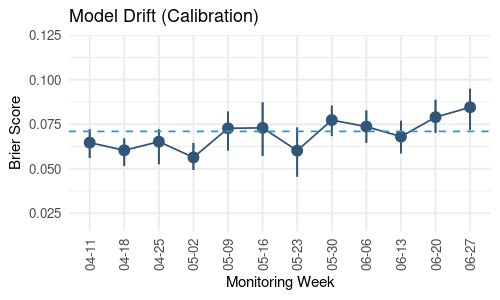

In [0]:
%r
ici_p <- ggplot(ici_results, aes(x=as.factor(week_date), y=ici, ymin=ici_lower, ymax=ici_upper, group=1)) + 
  geom_pointrange(col=ronin_colors[1]) + 
  geom_linerange(col=ronin_colors[1]) +
  geom_line(col=ronin_colors[1]) +
  geom_hline(yintercept=0.071, col=ronin_colors[2], linetype=2) +
#  annotate(geom="text", x=3.5, y=0.08, label="Training Brier Score", col=ronin_colors[2], size=3) +
  ylab("Brier Score") +
  xlab("Monitoring Week") +
  scale_x_discrete(labels=function(x) {substring(x, 6)}) +
  ggtitle("Model Drift (Calibration)") +
  coord_cartesian(ylim=c(0.02, 0.12)) +
  theme_minimal() +
  theme(
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    title=element_text(size=9),
    text=element_text(size=10))

options(repr.plot.width=500, repr.plot.height=300)
ici_p

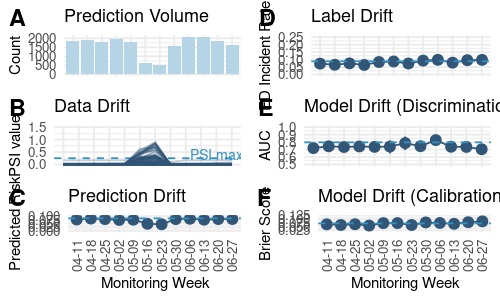

In [0]:
%r
# combined plot
options(repr.plot.width=800, repr.plot.height=700)

second_col <- plot_grid(vol_p, psi_p2, pred_p, nrow=3, rel_heights=c(0.3, 0.3, 0.4), labels=c("A", "B", "C"))
third_col <- plot_grid(ed_p, auc_p, ici_p, nrow=3, rel_heights=c(0.3, 0.3, 0.4), labels=c("D", "E", "F"))
combined_plot <- plot_grid(second_col, third_col, ncol=2)

combined_plot